In [13]:
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller

In [2]:
df = pd.read_csv("../data_manning/TimeSeriesForecastingInPython/data/widget_sales.csv")
df.head()

,widget_sales
0,50.496714
1,50.805493
2,51.477758
3,53.542228
4,54.873108


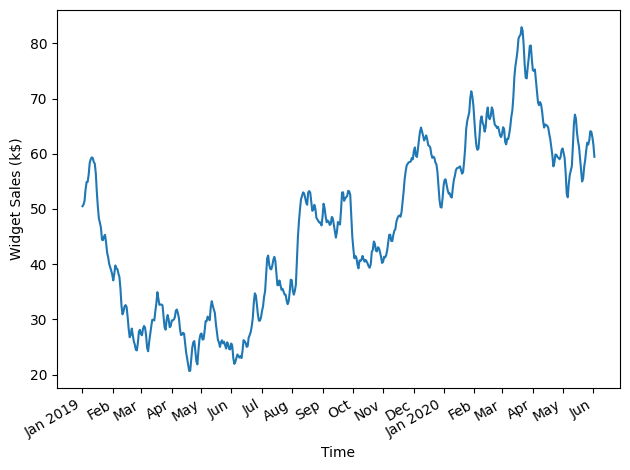

In [7]:
fig, ax = plt.subplots()
ax.plot(df["widget_sales"])
ax.set_xlabel("Time")
ax.set_ylabel("Widget Sales (k$)")

plt.xticks([0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498],
          ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec',
           'Jan 2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()

In [16]:
ADF_result = adfuller(df["widget_sales"])
print(f'ADF Statistic:  {ADF_result[0]}')
print(f'p-values: {ADF_result[1]}')

ADF Statistic:  -1.5121662069359045
p-values: 0.5274845352272606


In [17]:
import numpy as np

In [18]:
widget_sales_diff = np.diff(df["widget_sales"], n=1)

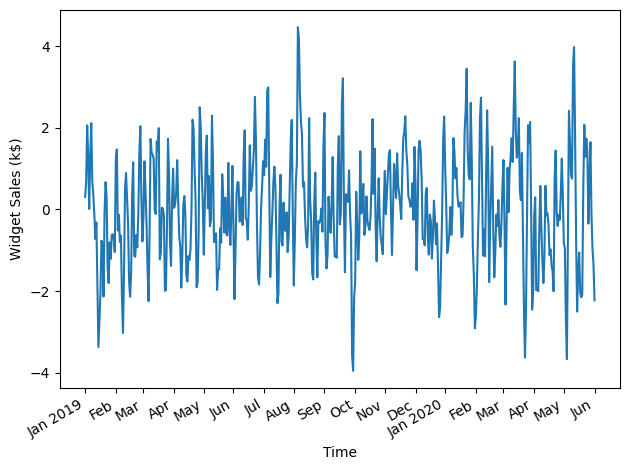

In [22]:
fig, ax = plt.subplots()
ax.plot(widget_sales_diff)
ax.set_xlabel("Time")
ax.set_ylabel("Widget Sales (k$)")

plt.xticks([0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498],
          ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec',
           'Jan 2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()

In [23]:
# Now run the adf test on differenced time series

In [26]:
ADF_result = adfuller(widget_sales_diff)
print(f"ADF Statistic: {ADF_result[0]}")
print(f"p-value: {ADF_result[1]}")    # Now the series becomes stationary

ADF Statistic: -10.576657780341959
p-value: 7.076922818587193e-19


In [29]:
from statsmodels.graphics.tsaplots import plot_acf

(-1.0, 1.1)

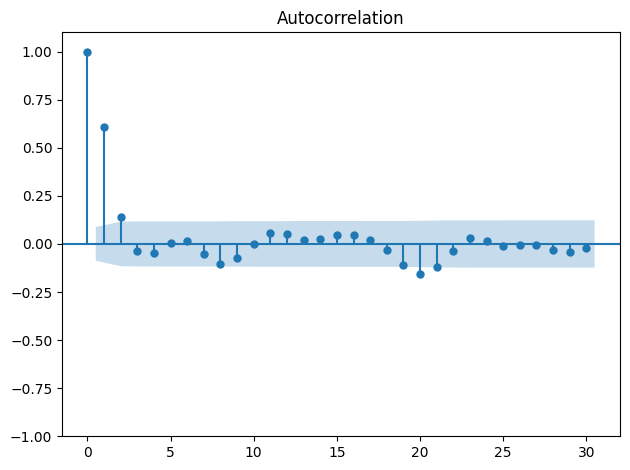

In [34]:
plot_acf(widget_sales_diff, lags=30)
plt.tight_layout()
plt.ylim(-1,1.1)

In [36]:
df_diff = pd.DataFrame({"widget_sales_diff":widget_sales_diff})

In [37]:
train = df_diff[:int(0.9 * len(df_diff))]
test = df_diff[int(0.9 * len(df_diff)):]

In [38]:
print(len(train))
print(len(test))

449
50


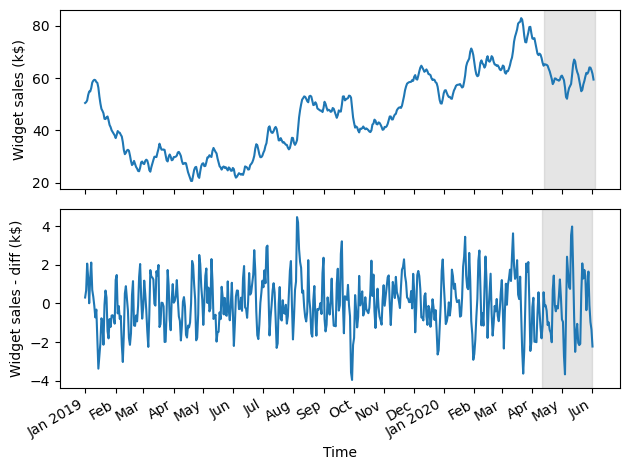

In [53]:
fig,(ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)
ax1.plot(df["widget_sales"])
ax1.set_xlabel('Time')
ax1.set_ylabel('Widget sales (k$)')
ax1.axvspan(450, 500, color='#808080', alpha=0.2)


ax2.plot(df_diff["widget_sales_diff"])
ax2.set_xlabel('Time')
ax2.set_ylabel('Widget sales - diff (k$)')
ax2.axvspan(448, 498, color='#808080', alpha=0.2)
plt.xticks(
    [0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498], 
    ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 
     'Jan 2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])



fig.autofmt_xdate()
plt.tight_layout()

In [54]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [63]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window:int, method:str ) -> list:
    total_len = train_len + horizon
    
    if method == "mean":
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
            
        return pred_mean
    
    elif method == "last":
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
        
        return pred_last_value
    
    elif method == "MA":
        pred_MA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(0,0,2))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i+window-1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_MA.extend(oos_pred)
        return pred_MA

In [64]:
pred_df = test.copy()

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

In [67]:
pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, "mean")
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, "last")
pred_MA = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, "MA")

pred_df['pred_mean'] = pred_mean
pred_df['pred_last_value'] = pred_last_value
pred_df["pred_MA"] = pred_MA

In [68]:
pred_df

,widget_sales_diff,pred_mean,pred_last_value,pred_MA
449,-1.170131,0.034319,-1.803658,-1.078833
450,0.580967,0.034319,-1.803658,-0.273309
451,-0.144902,0.032861,0.580967,0.781223
452,-0.096564,0.032861,0.580967,0.234969
453,-0.372334,0.032183,-0.096564,0.168994
454,-1.118891,0.032183,-0.096564,0.115810
455,-0.979693,0.028764,-1.118891,-0.795666
456,-1.369431,0.028764,-1.118891,-0.191286
457,-1.517477,0.023498,-1.369431,-0.922824
458,-2.006735,0.023498,-1.369431,-0.254060


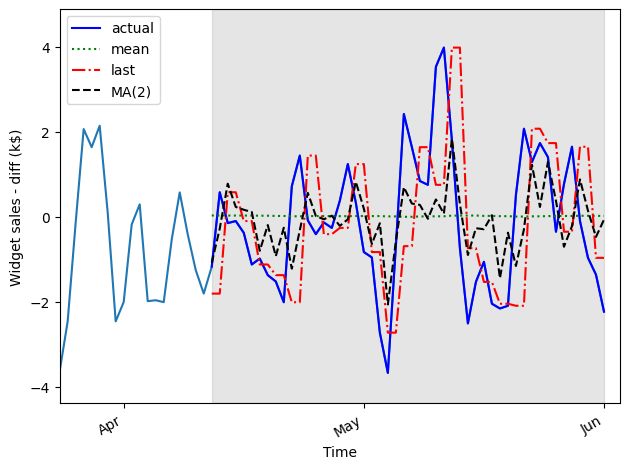

In [89]:
fig, ax = plt.subplots()

ax.plot(df_diff["widget_sales_diff"])
ax.plot(pred_df['widget_sales_diff'], 'b-', label='actual')
ax.plot(pred_df['pred_mean'],'g:', label='mean')
ax.plot(pred_df['pred_last_value'],'r-.', label='last')
ax.plot(pred_df['pred_MA'],'k--', label='MA(2)')

ax.axvspan(449,498, color='#808080', alpha=0.2)

ax.set_xlabel('Time')
ax.set_ylabel('Widget sales - diff (k$)')




plt.legend()
plt.xlim(430,500)
plt.xticks([438,468,498],['Apr','May','Jun'])

fig.autofmt_xdate()
plt.tight_layout()



In [90]:
from sklearn.metrics import mean_squared_error

In [91]:
mse_mean = mean_squared_error(pred_df["widget_sales_diff"], pred_df["pred_mean"])
mse_last = mean_squared_error(pred_df["widget_sales_diff"], pred_df["pred_last_value"])
mse_MA = mean_squared_error(pred_df['widget_sales_diff'], pred_df['pred_MA'])

print(mse_mean, mse_last, mse_MA)

2.5606299456880537 3.2494260812249225 1.948171449749372


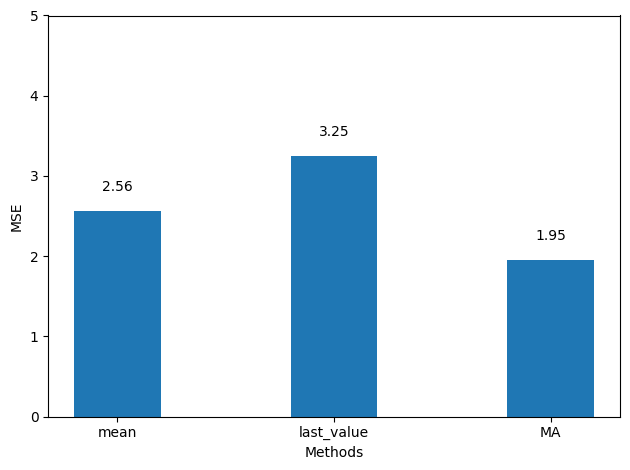

In [96]:
fig, ax = plt.subplots()

x = ["mean", "last_value", "MA"]
y = [mse_mean, mse_last, mse_MA]

ax.bar(x, y, width=0.4)
ax.set_xlabel("Methods")
ax.set_ylabel("MSE")
ax.set_ylim(0,5)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.25, s=str(round(value,2)), ha='center')

plt.tight_layout()

In [97]:
df["pred_widget_sales"] = pd.Series()
df["pred_widget_sales"][450:] = df["widget_sales"].iloc[450] + pred_df["pred_MA"].cumsum()

c:\users\mahes\desktop\x training\time_series2\time_series\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


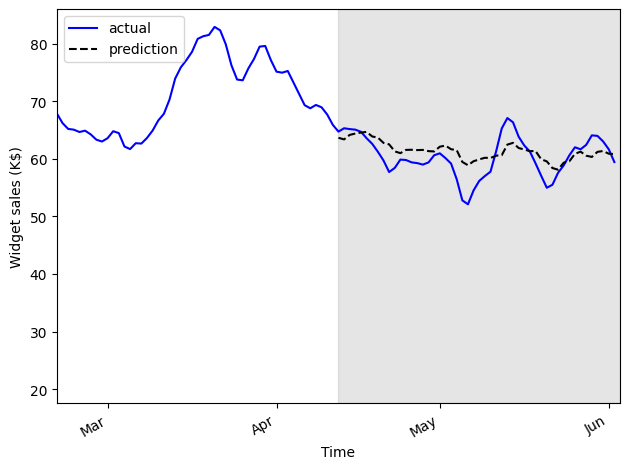

In [106]:
fig, ax = plt.subplots()

ax.plot(df["widget_sales"], 'b-', label='actual')
ax.plot(df["pred_widget_sales"], 'k--', label='prediction')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Widget sales (K$)')

ax.set_xlim(400, 500)
plt.xticks(
    [409, 439, 468, 498], 
    ['Mar', 'Apr', 'May', 'Jun'])

ax.axvspan(450,500, color='#808080', alpha=0.2)

fig.autofmt_xdate()
plt.tight_layout()

In [107]:
from sklearn.metrics import mean_absolute_error

In [109]:
mea_MA_undiff = mean_absolute_error(df["widget_sales"].iloc[450:], df['pred_widget_sales'].iloc[450:])
print(mea_MA_undiff)

2.324470924449857
